Objective of this notebook is to copy vicreg weights to new model and run prediction

In [10]:
import argparse
import numpy as np
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score as auprc
from sklearn.metrics import roc_auc_score as auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

import keras

#from keras.utils import multi_gpu_model
from keras.layers import Input, Dense, GRU, Lambda, Permute, Concatenate, Dropout
from keras.models import Model
from interpolation_layer import single_channel_interp, cross_channel_interp
from mimic_preprocessing import load_data, trim_los, fix_input_format
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

np.random.seed(10)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "01"

In [3]:
import sys
sys.path
if '/home/ugrads/n/nickcheng0921/TAMU-MedResearch/' not in sys.path:
    sys.path.append('/home/ugrads/n/nickcheng0921/TAMU-MedResearch/')
from helper import hold_out, mean_imputation

In [4]:
gpu_num = 1
epoch = 1000
hid = 256 #can be 128-512
ref_points = 128
hours_look_ahead = 48
if gpu_num > 0:
    batch = 512*gpu_num
else:
    batch = 512
    
#vicreg parameters
epsilon = .0001 #small scalar to prevent numerical instabilities
gamma = 1 #constant target value for SD

#nicks notes args
vocabulary = 6000

# Load patients

In [5]:
# Loading dataset - explanation in multivariate notebook
vitals, label = load_data(look_ahead_time = hours_look_ahead)
vitals, timestamps = trim_los(vitals, hours_look_ahead)
x, m, T = fix_input_format(vitals, timestamps)
mean_imputation(x, m)
x = np.concatenate((x, m, T, hold_out(m)), axis=1)  # input format
y = np.array(label)
print(f"X shape: {x.shape}, Y shape: {y.shape}")
timestamp = x.shape[2]
num_features = x.shape[1] // 4
#     have an array representation.
# m : (N, D, tn) where m[i,j,k] = 0 means that x[i,j,k] is not observed.
# T : (N, D, tn) represents the actual time stamps of observation;

Loading files ...
Loading Done with 12000 patients! Nick
10852 10852
(10852, 12, 200) 10852
X shape: (10852, 48, 200), Y shape: (10852,)


In [6]:
import pickle
patient_notes = pickle.load(open('notes_12000_'+str(hours_look_ahead)+'hrs.p', 'rb'))

In [7]:
from keras.losses import mse
from keras import backend as K

# Copy Model

In [16]:
def customloss(ytrue, ypred):
    """ Autoencoder loss
    """
    # standard deviation of each feature mentioned in paper for MIMIC_III data
    wc = np.array([3.33, 23.27, 5.69, 22.45, 14.75, 2.32,
                   3.75, 1.0, 98.1, 23.41, 59.32, 1.41])
    wc.shape = (1, num_features)
    y = ytrue[:, :num_features, :]
    m2 = ytrue[:, 3*num_features:4*num_features, :]
    m2 = 1 - m2
    m1 = ytrue[:, num_features:2*num_features, :]
    m = m1*m2
    ypred = ypred[:, :num_features, :]
    x = (y - ypred)*(y - ypred)
    x = x*m
    count = tf.reduce_sum(m, axis=2)
    count = tf.where(count > 0, count, tf.ones_like(count))
    x = tf.reduce_sum(x, axis=2)/count
    x = x/(wc**2)  # dividing by standard deviation
    x = tf.reduce_sum(x, axis=1)/num_features
    return tf.reduce_mean(x)

seed = 0
results = {}
results['loss'] = []
results['auc'] = []
results['acc'] = []
results['auprc'] = []

# interpolation-prediction network


def interp_net():
    if gpu_num > 1:
        dev = "/cpu:0"
    else:
        dev = "/gpu:0"
    with tf.device(dev):
        main_input = Input(shape=(4*num_features, timestamp), name='input')
        notes_input = Input(shape=(vocabulary), name='notes_input')
        notes_output = Dense(hid, activation='sigmoid', name='text_dense_1')(notes_input)
        notes_output = Dropout(0.2)(notes_output)
        notes_output = Dense(hid, activation='sigmoid', name='text_dense_2')(notes_output)
        notes_output = Dropout(0.2, name='notes_output')(notes_output)
        sci = single_channel_interp(ref_points, hours_look_ahead)
        cci = cross_channel_interp()
        interp = cci(sci(main_input))
        reconst = cci(sci(main_input, reconstruction=True),
                      reconstruction=True)
        aux_output = Lambda(lambda x: x, name='aux_output')(reconst)
        z = Permute((2, 1))(interp)
        z = GRU(hid, activation='tanh', recurrent_dropout=0.2, dropout=0.2, name='series_output')(z)
        merged_input = Concatenate()([notes_output, z])
        #print(f"Z SHAPE {z.shape} NOTES SHAPE {notes_input.shape} MERGED SHAPE {merged_input.shape}")
        main_output = Dense(1, activation='sigmoid', name='main_output')(merged_input)
        orig_model = Model([main_input, notes_input], [main_output, aux_output])
    if gpu_num > 1:
        model = multi_gpu_model(orig_model, gpus=gpu_num)
    else:
        model = orig_model
    #print(orig_model.summary())
    return model

class FusionModel(object):
    def __init__(self):
        if gpu_num > 1:
            dev = "/cpu:0"
        else:
            dev = "/gpu:0"
        with tf.device(dev):
            self.notes_input = Input(shape=(vocabulary), name='notes_input')
            self.notes_output = Dense(hid, activation='sigmoid', name='text_dense_1')(self.notes_input)
            self.notes_output = Dropout(0.2)(self.notes_output)
            self.notes_output = Dense(hid, activation='sigmoid', name='text_dense_2')(self.notes_output)
            self.notes_output = Dropout(0.2)(self.notes_output)
            self.notes_output = Dense(hid, activation='sigmoid', name='notes_output')(self.notes_output)
            
            self.main_input = Input(shape=(4*num_features, timestamp), name='input')
            self.sci = single_channel_interp(ref_points, hours_look_ahead)
            self.cci = cross_channel_interp()
            self.interp = self.cci(self.sci(self.main_input))
            self.reconst = self.cci(self.sci(self.main_input, reconstruction=True),
                          reconstruction=True)
            self.aux_output = Lambda(lambda x: x, name='aux_output')(self.reconst)
            self.z = Permute((2, 1))(self.interp)
            self.z = GRU(hid, activation='tanh', recurrent_dropout=0.2, dropout=0.2, name='series_output')(self.z)
            #print(f"Z SHAPE {z.shape} NOTES SHAPE {notes_input.shape} MERGED SHAPE {merged_input.shape}")
            self.merged_output = Concatenate(name='merged_output')([self.notes_output, self.z])
            self.model = Model([self.main_input, self.notes_input], [self.merged_output, self.aux_output])
            
            trainable_count = np.sum([K.count_params(w) for w in self.model.trainable_weights])
            print(f"train params: {trainable_count}")

earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0000, patience=20, verbose=0)
callbacks_list = [earlystop]

# Run model

In [17]:
src = FusionModel().model

train params: 1893632


In [18]:
src.load_weights('reg3.weights')

In [19]:
# https://medium.com/howtoai/model-surgery-copy-weights-from-model-to-model-a31b1dec7a7a
def copyModel2Model(model_source, model_target, names=[]):
    for l_tg in model_target.layers:
        if l_tg.name in names:
            model_target.get_layer(l_tg.name).set_weights(model_source.get_layer(l_tg.name).get_weights())
            print("Transferred", l_tg.name)

In [20]:
i = 0
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
notes_vectorizer = TfidfVectorizer(max_features=vocabulary)

for train, test in kfold.split(np.zeros(len(y)), y):
    print("Running Fold:", i+1)
    model = interp_net()  # re-initializing every time
    copyModel2Model(src, model, names=['series_output', 'text_dense_1', 'text_dense_2', 'aux_output'])
    kfold_notes_train = [patient_notes[i] for i in train]
    kfold_notes_test = [patient_notes[i] for i in test]
    notes_tfidf = notes_vectorizer.fit(kfold_notes_train) #train vocab on train set, then use vectorizer on test set
    model.compile(
        optimizer='adam',
        loss={'main_output': 'binary_crossentropy', 'aux_output': customloss},
        loss_weights={'main_output': 1., 'aux_output': 1.},
        metrics={'main_output': 'accuracy'})
    model.fit(
        {'input': x[train], 'notes_input': notes_vectorizer.transform(kfold_notes_train).todense()}, {'main_output': y[train], 'aux_output': x[train]},
        batch_size=batch,
        callbacks=callbacks_list,
        epochs=epoch,
        validation_split=0.20,
        verbose=2)
    y_pred = model.predict({'input': x[test], 'notes_input': notes_vectorizer.transform(kfold_notes_test).todense()}, batch_size=batch)
    y_pred = y_pred[0]
    total_loss, score, reconst_loss, acc = model.evaluate(
        {'input': x[test], 'notes_input': notes_vectorizer.transform(kfold_notes_test).todense()}, {'main_output': y[test], 'aux_output': x[test]},
        batch_size=batch,
        verbose=0)
    results['loss'].append(score)
    results['acc'].append(acc)
    results['auc'].append(auc_score(y[test], y_pred))
    results['auprc'].append(auprc(y[test], y_pred))
    print(results, "RECONST LOSS:", reconst_loss)
    del model
    i += 1

Running Fold: 1
Transferred text_dense_1
Transferred text_dense_2
Transferred series_output
Transferred aux_output
Epoch 1/1000
14/14 - 14s - loss: 0.6262 - main_output_loss: 0.3106 - aux_output_loss: 0.3157 - main_output_accuracy: 0.9133 - val_loss: 0.6442 - val_main_output_loss: 0.3201 - val_aux_output_loss: 0.3241 - val_main_output_accuracy: 0.9217 - 14s/epoch - 1s/step
Epoch 2/1000
14/14 - 9s - loss: 0.5845 - main_output_loss: 0.2689 - aux_output_loss: 0.3157 - main_output_accuracy: 0.9169 - val_loss: 0.6018 - val_main_output_loss: 0.2777 - val_aux_output_loss: 0.3241 - val_main_output_accuracy: 0.9217 - 9s/epoch - 609ms/step
Epoch 3/1000
14/14 - 9s - loss: 0.5826 - main_output_loss: 0.2669 - aux_output_loss: 0.3157 - main_output_accuracy: 0.9175 - val_loss: 0.6304 - val_main_output_loss: 0.3063 - val_aux_output_loss: 0.3241 - val_main_output_accuracy: 0.9217 - 9s/epoch - 627ms/step
Epoch 4/1000
14/14 - 9s - loss: 0.5699 - main_output_loss: 0.2542 - aux_output_loss: 0.3157 - main_o

Text(0.2, 0.3, 'Avg auc 0.852')

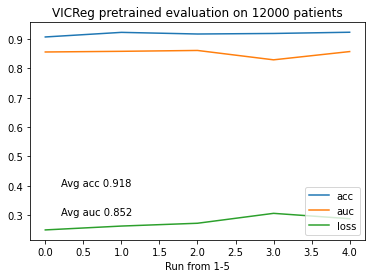

In [22]:
plt.plot(results['acc'], label='acc')
plt.plot(results['auc'], label='auc')
plt.plot(results['loss'], label='loss')
plt.legend(loc="lower right")
plt.title(f"VICReg pretrained evaluation on 12000 patients")
plt.xlabel("Run from 1-5")
plt.text(.2, .4,f"Avg acc {np.mean(results['acc']):.3f}")
plt.text(.2, .3,f"Avg auc {np.mean(results['auc']):.3f}")
#plt.savefig("vicrun2.png")